In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import os
import torch.onnx
import pandas as pd
import matplotlib.pyplot as plt
from fastai.widgets import *
%matplotlib inline

#### 1.渐进的图像尺寸
##### 使用两个大小不同的图像集，112 * 112和224 * 224，先在112 * 112数据集上训练，得到最佳模型后继续在224 * 224数据集上训练，同样得到最佳模型后解冻，训练所有层。

In [2]:
# 加载数据
path = 'data/train/'
df_train = pd.read_csv('cleaned/df_train_cleaned.csv',index_col=0)
df_valid = pd.read_csv('cleaned/df_valid_cleaned.csv',index_col=0)
df = df_train.append(df_valid)

In [3]:
ospath = os.getcwd()

In [4]:
data_small = ImageDataBunch.from_df(path=os.path.join(ospath,'data'),
                                    folder='train',
                                    df=df,
                                    ds_tfms=get_transforms(),
                                    size =112,
                                    test = 'test',
                                    bs = 128).normalize(imagenet_stats) 

In [5]:
data_large = ImageDataBunch.from_df(path=os.path.join(ospath,'data'),
                                    folder='train',
                                    df=df,
                                    ds_tfms=get_transforms(),
                                    size =224,
                                    test = 'test',
                                    bs=64).normalize(imagenet_stats) 

In [6]:
learn = cnn_learner(data_small, models.resnet50, pretrained=False, metrics=error_rate)
learn.load('resnet50');
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 1.00E-02


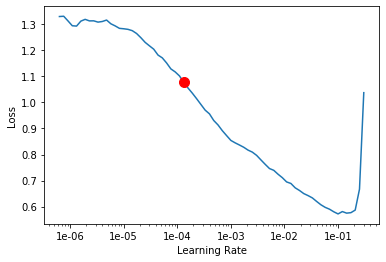

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [29]:
cb = SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='small_freeze')
learn.fit_one_cycle(3, 3E-3, callbacks=[cb])

epoch,train_loss,valid_loss,error_rate,time
0,0.155930,0.084932,0.033093,01:42
1,0.073529,0.053962,0.020257,01:48
2,0.050955,0.051175,0.019053,01:46


Better model found at epoch 0 with valid_loss value: 0.0849316418170929.
Better model found at epoch 1 with valid_loss value: 0.053961653262376785.
Better model found at epoch 2 with valid_loss value: 0.051174551248550415.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


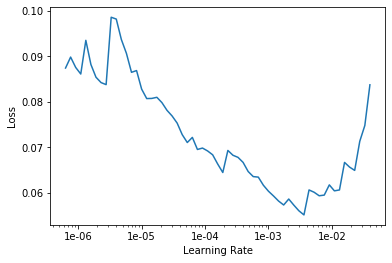

In [8]:
learn.data = data_large
learn.load('small_freeze')
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.load('small_freeze')
cb = SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='large_freeze')
learn.fit_one_cycle(3, 1E-4, callbacks=[cb])

epoch,train_loss,valid_loss,error_rate,time
0,0.057721,0.025381,0.009627,03:22
1,0.035126,0.025527,0.009226,03:22
2,0.013708,0.018002,0.005215,03:21


Better model found at epoch 0 with valid_loss value: 0.025381147861480713.
Better model found at epoch 2 with valid_loss value: 0.01800219528377056.


In [26]:
#learn.data = data_large
learn.load('large_freeze');
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


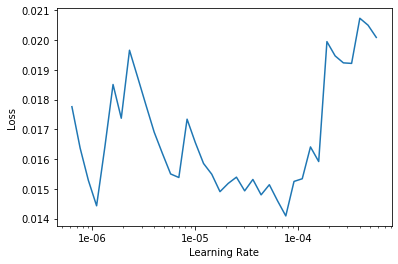

In [29]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.load('large_freeze');
learn.unfreeze()
cb = SaveModelCallback(learn, every='epoch', monitor='valid_loss', name='large_unfreeze')
learn.fit_one_cycle(3, max_lr=slice(1E-7,1E-5), callbacks=[cb])

epoch,train_loss,valid_loss,error_rate,time
0,0.016211,0.018324,0.006017,03:20
1,0.018319,0.017248,0.005215,03:20
2,0.013011,0.017577,0.005415,03:23


In [21]:
learn.load('large_freeze');
learn.unfreeze()
cb = SaveModelCallback(learn, every='epoch', monitor='valid_loss', name='large_unfreeze')
learn.fit_one_cycle(3, max_lr=slice(3E-6,3E-4), callbacks=[cb])

epoch,train_loss,valid_loss,error_rate,time
0,0.027002,0.022692,0.007421,03:19
1,0.029394,0.016743,0.006017,03:20
2,0.014488,0.016215,0.004613,03:20


In [16]:
def to_csvfile(x,pred_list,path):
    idx_list = []
    for file in x.items:
        idx = int(file.name.split('.')[0])
        idx_list.append(idx)
    res = pd.DataFrame({'id': idx_list, 'label': pred_list})
    res.sort_values(by='id', inplace=True)
    res.reset_index(drop=True, inplace=True)
    res.to_csv(path, index=False)

In [31]:
#learn.load('large_freeze11');
preds,y = learn.get_preds(ds_type=DatasetType.Test)
pred_list = preds.numpy()[:,1]
path = 'csv/large_unfreeze.csv'
to_csvfile(learn.data.test_ds.x, pred_list, path)

#### TTA

In [33]:
learn.load('large_freeze');
preds,y,losses = learn.TTA(ds_type=DatasetType.Test, with_loss=True)
pred_list = preds.numpy()[:,1]
path = 'csv/large_unfreeze_TTA.csv'
to_csvfile(learn.data.test_ds.x, pred_list, path)

#### 2.使用层数更多的 resnet152模型测试效果

In [ ]:
data = ImageDataBunch.from_df(path=os.path.join(ospath,'data'),
                                    folder='train',
                                    df=df,
                                    ds_tfms=get_transforms(),
                                    size =224,
                                    test = 'test',
                                    bs=32).normalize(imagenet_stats) 

In [5]:
learn = cnn_learner(data, models.resnet152, pretrained=False, metrics=error_rate)
learn.load('resnet152');
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 2.29E-03


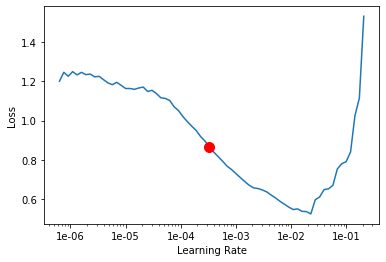

In [6]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
#learn.load('resnet152');
learn.fit_one_cycle(1, 3E-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.048601,0.033645,0.012000,06:06


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.55E-09
Min loss divided by 10: 1.62E-10


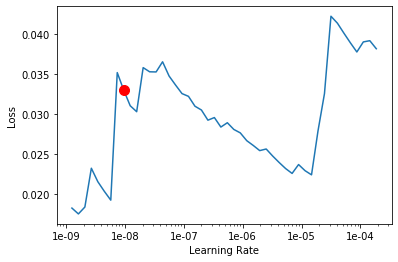

In [12]:
learn.unfreeze()
learn.lr_find(start_lr=1E-8)
learn.recorder.plot(suggestion=True)

In [21]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.039775,0.026448,0.008200,08:09
1,0.029895,0.027310,0.010200,08:09
2,0.014691,0.025159,0.008200,08:12
3,0.015713,0.024104,0.008200,08:10


In [22]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
pred_list = preds.numpy()[:,1]

In [25]:
path = 'csv/fit_one_cycle_152.csv'
to_csvfile(learn.data.test_ds.x, pred_list, path)